# Modèles ARMA sur l'indice de production industrielle du log du commerce d'éléctricité

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
sns.set()
%matplotlib inline
import scipy.stats as stats

#### Chargement des données brutes

In [2]:
import os
os.getcwd()

'/Users/admin/Desktop/ENSAE/2A/S2/Séries temporelles/Projet/TimeSeries'

In [4]:
dfE = pd.read_csv(
   "Electricite/valeurs_mensuelles.csv",
    sep=";",
    skiprows=[1, 2],
    index_col="Libellé",
    parse_dates=["Libellé"])
dfE.columns = ["Electricite","ToDelete"]
del(dfE["ToDelete"])

log_dfE = np.log(dfE)
log_dfE.head()

,Electricite
Libellé,
1990-01-01,4.455277
1990-02-01,4.209606
1990-03-01,4.228147
1990-04-01,4.173618
1990-05-01,3.936130


#### Chargement des données stationnarisées

In [11]:
s = pd.read_csv("Electricite/stationnaire.csv", header=None, index_col=0)
s.columns = ["Electricite"]
s.index.names = ['Date']
s.head()

,Electricite
Date,
1990-02-01,-0.125571
1990-03-01,0.067431
1990-04-01,0.115244
1990-05-01,-0.112320
1990-06-01,0.051904


## Etude et comparaison de différents modèles ARMA

### Sélection des ordres $p^*, q^*$

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Etude des autocorrélogrammes partiels et totaux de la série $\tilde{X_t}$

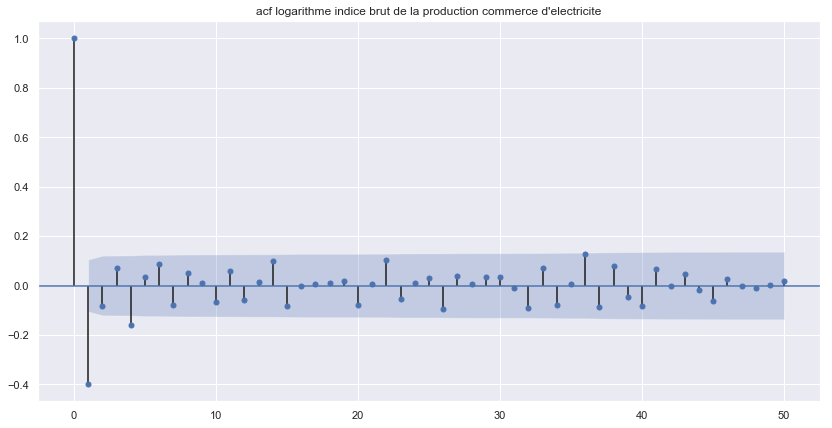

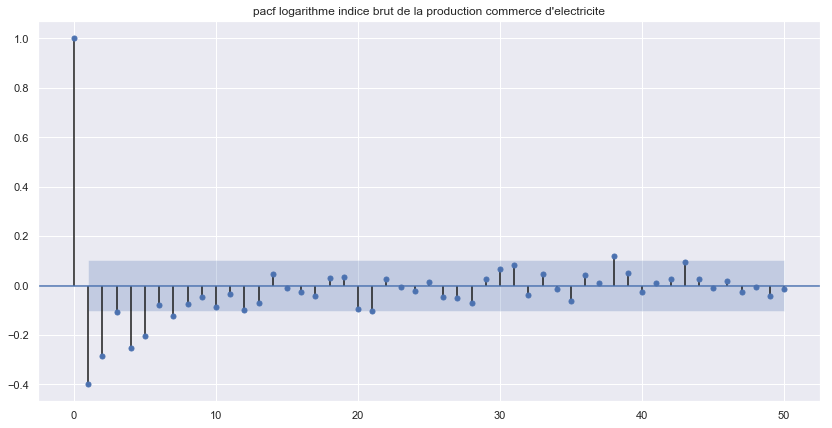

In [14]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,7))

    plot_acf(s, lags=50,
             title="acf logarithme indice brut de la production commerce d'electricite")
    #plt.savefig("Images/acf.png")

    plot_pacf(s, lags=50,
             title="pacf logarithme indice brut de la production commerce d'electricite")
    #plt.savefig("Images/pacf.png")

**Commentaires:** L'ordre $q$ vraisemblable $\in \{0, 1, 3, 4\}$

L'ordre $p$ vraisemblable $\in \{0, 1, 2, 3, 4, 5, 6, 7\}$


### Sélection de modèles ARMA - Critères de l'AIC et du BIC

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
from statsmodels.tsa.arima_model import ARMA
from statsmodels.stats.diagnostic import acorr_ljungbox

On cherche à sélectionner parmi les modèles valides (dont les résidus sont des bruits blancs) et ayant un bon ajustement celui qui minimise les deux critères d'information AIC et BIC:

In [141]:
def evaluate_arma_ic(dataset, p_values, q_values):
    """"""

    best_aic, best_bic, ljung_box, pvalues_coef = [], [], None, []
    
    for p in p_values:
            for q in q_values:
                
                            my_order = (p,q)
                    
                            try:
                                
                                model = ARMA(dataset, order=my_order)
                                model_fit = model.fit()
                                
                                # On prend la dernière p-value du test Ljung-box et on compare à 0.05
                                ljung_box = acorr_ljungbox(model_fit.resid)[1][-1]
                                
                                if ljung_box > 0.05:
                                
                                    # On regarde l'ajustement des modèles valides
                                    
                                    if p>0:
                                        pvalues_coef.append(model_fit.pvalues["ar.L" + str(p) + ".Electricite"])
                                    if q>0:
                                        pvalues_coef.append(model_fit.pvalues["ma.L" + str(q) + ".Electricite"])
                                    
                                    if max(pvalues_coef) < 0.05 :
                                    
                                        best_aic.append([my_order, model_fit.aic])
                                        best_bic.append([my_order, model_fit.bic])
                                        
                                    pvalues_coef = []
                                    
                            except:
                                
                                print("je n'ai pas convergé : {}".format(my_order))
                                continue
                                
    return best_aic, best_bic

In [38]:
p_values = [0, 1, 2, 3, 4, 5, 6, 7]
q_values = [0, 1, 2, 3, 4]

In [142]:
best_aic, best_bic = evaluate_arma_ic(s, p_values, q_values)

je n'ai pas convergé : (0, 4)
je n'ai pas convergé : (5, 2)
je n'ai pas convergé : (5, 3)
je n'ai pas convergé : (6, 4)


In [145]:
sorted(best_aic, key=lambda x:x[1])

[[(4, 4), -1181.3390926610953],
 [(4, 1), -1180.9296419146115],
 [(1, 1), -1179.6781251767677],
 [(0, 2), -1179.2925672191352],
 [(3, 3), -1177.723612365878],
 [(2, 2), -1177.641689667564],
 [(2, 3), -1176.1770850438959],
 [(7, 0), -1169.6408229537535],
 [(5, 0), -1165.8078742355822]]

In [146]:
sorted(best_bic, key=lambda x:x[1])

[[(1, 1), -1164.257837487958],
 [(0, 2), -1163.8722795303256],
 [(2, 2), -1154.5112581343494],
 [(4, 1), -1153.9441384591944],
 [(2, 3), -1149.1915815884788],
 [(3, 3), -1146.8830369882585],
 [(4, 4), -1142.788373439071],
 [(5, 0), -1138.822370780165],
 [(7, 0), -1134.9451756539318]]

* $ARMA(4,4)$

In [147]:
arma_model = ARMA(s, order=(4,4)).fit()
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            Electricite   No. Observations:                  349
Model:                     ARMA(4, 4)   Log Likelihood                 600.670
Method:                       css-mle   S.D. of innovations              0.043
Date:                Wed, 24 Apr 2019   AIC                          -1181.339
Time:                        10:42:28   BIC                          -1142.788
Sample:                    02-01-1990   HQIC                         -1165.993
                         - 02-01-2019                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0013      0.001      2.310      0.021       0.000       0.002
ar.L1.Electricite     0.3690      0.406      0.909      0.364      -0.427       1.165
ar.L2.Electricite     0.2886      0.332      0.870      0.385      -0.361       0.938
ar.L3.Electricite     0.5939      0.192      3.095      0.002       0.218       0.970
ar.L4.Electricite    -0.2815      0.070     -4.011      0.000      -0.419      -0.144
ma.L1.Electricite    -1.0856      0.430     -2.527      0.012      -1.928      -0.243
ma.L2.Electricite    -0.1430      0.682     -0.210      0.834      -1.480       1.194
ma.L3.Electricite    -0.3420      0.277     -1.235      0.218      -0.885       0.201
ma.L4.Electricite     0.5785      0.197      2.935      0.004       0.192       0.965
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7055           -0.9466j            1.1806           -0.3519
AR.2           -0.7055           +0.9466j            1.1806            0.3519
AR.3            1.0186           -0.0000j            1.0186           -0.0000
AR.4            2.5025           -0.0000j            2.5025           -0.0000
MA.1           -0.7234           -1.0662j            1.2884           -0.3449
MA.2           -0.7234           +1.0662j            1.2884            0.3449
MA.3            1.0190           -0.0547j            1.0205           -0.0085
MA.4            1.0190           +0.0547j            1.0205            0.0085
-----------------------------------------------------------------------------
"""

* $ARMA(1,1)$

In [94]:
arma_model = ARMA(s, order=(1,1)).fit()
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            Electricite   No. Observations:                  349
Model:                     ARMA(1, 1)   Log Likelihood                 593.839
Method:                       css-mle   S.D. of innovations              0.044
Date:                Wed, 24 Apr 2019   AIC                          -1179.678
Time:                        09:54:40   BIC                          -1164.258
Sample:                    02-01-1990   HQIC                         -1173.540
                         - 02-01-2019                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0013      0.000      4.084      0.000       0.001       0.002
ar.L1.Electricite     0.1963      0.061      3.216      0.001       0.077       0.316
ma.L1.Electricite    -0.8931      0.027    -32.962      0.000      -0.946      -0.840
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            5.0952           +0.0000j            5.0952            0.0000
MA.1            1.1197           +0.0000j            1.1197            0.0000
-----------------------------------------------------------------------------
"""

### Sélection de modèles ARMA - Critères de la MSE

On cherche, parmi les modèles valides et à bon ajustement, celui qui minimise le critère de la MSE:

In [64]:
from sklearn.metrics import mean_squared_error

In [151]:
def evaluate_arma_mse(dataset, p_values, q_values):
    """"""

    N = dataset.shape[0]
    train = dataset.iloc[1:(N-6)]
    test = dataset.iloc[(N-6):N]
    
    #best_aic, best_bic, best_cfg_1, best_cfg_2, ljung_box = float("inf"), float("inf"), None, None, None
    best_mse, ljung_box = [], None
    
    for p in p_values:
            for q in q_values:
                            
                            my_order = (p, q)
                            
                            try:
                                
                                model = ARMA(train, order=my_order)
                                model_fit = model.fit()
                                
                                # On prend la dernière p-value du test Ljung-box et on compare à 0.01
                                ljung_box = acorr_ljungbox(model_fit.resid)[1][-1]
                                
                                if ljung_box > 0.05:
                                
                                    # On regarde la MSE
                                    
                                    pred = model_fit.forecast(6)[0]
                                    best_mse.append([my_order, round(mean_squared_error(pred,test),6)])
                                    
                            except:
                                
                                print("je n'ai pas convergé : {}".format(my_order))
                                continue
                                
    return sorted(best_mse, key=lambda x:x[1])

In [152]:
best_mse = evaluate_arma_mse(s, p_values, q_values)

je n'ai pas convergé : (0, 4)
je n'ai pas convergé : (5, 4)
je n'ai pas convergé : (6, 4)


In [153]:
best_mse

[[(5, 3), 0.00408],
 [(4, 4), 0.004092],
 [(3, 3), 0.004172],
 [(7, 0), 0.004242],
 [(6, 2), 0.004426],
 [(0, 2), 0.004522],
 [(3, 2), 0.00453],
 [(3, 1), 0.004535],
 [(0, 3), 0.004538],
 [(1, 4), 0.004539],
 [(1, 3), 0.004542],
 [(1, 1), 0.004543],
 [(2, 1), 0.004543],
 [(1, 2), 0.004544],
 [(5, 1), 0.004568],
 [(7, 1), 0.004573],
 [(4, 2), 0.004606],
 [(4, 1), 0.004611],
 [(7, 4), 0.004613],
 [(5, 2), 0.004615],
 [(3, 4), 0.004631],
 [(7, 3), 0.004647],
 [(6, 3), 0.004689],
 [(6, 1), 0.004713],
 [(5, 0), 0.004742],
 [(4, 3), 0.004746],
 [(2, 4), 0.004749],
 [(2, 2), 0.004773],
 [(7, 2), 0.00481],
 [(2, 3), 0.004842],
 [(6, 0), 0.005175]]

**Remarque:** Certains modèles qui n'était pas valides et/ou à bon ajustement avant le deviennent maintenant car on ne sélectionne pas la même BDD ici. Pour la suite, nous allons calculer la MSE et l'AIC et BIC en même temps pour ne pas avoir ce problème.

## Sorties $\LaTeX$

### Tableau avec tous les modèles testés

In [123]:
def evaluate_arma_mseic(dataset, p_values, q_values):
    """"""

    N = dataset.shape[0]
    train = dataset.iloc[1:(N-6)]
    test = dataset.iloc[(N-6):N]
    
    tableau, mse = [], []
    
    for p in p_values:
            for q in q_values:
                            
                            my_order = (p, q)
                            
                            try:
                                
                                model = ARMA(dataset, order=my_order)
                                model_fit = model.fit()
                                
                                model2 = ARMA(train, order=my_order)
                                model2_fit = model2.fit()
                                
                                pred = model2_fit.forecast(6)[0]
                                mse = round(mean_squared_error(pred,test),6)
                                
                                tableau.append([my_order, model_fit.aic, model_fit.bic, mse])
                                    
                            except:
                                
                                print("je n'ai pas convergé : {}".format(my_order))
                                continue
                                
    return tableau

In [113]:
tab1 = evaluate_arma_mseic(s, p_values, q_values)

je n'ai pas convergé : (0, 4)
je n'ai pas convergé : (5, 2)
je n'ai pas convergé : (5, 3)
je n'ai pas convergé : (5, 4)
je n'ai pas convergé : (6, 4)


In [115]:
tab1_df = pd.DataFrame(tab1, columns=["(p,q)","AIC","BIC", "MSE"])

In [116]:
print(tab1_df.to_latex())

\begin{tabular}{llrrr}
\toprule
{} &   (p,q) &          AIC &          BIC &       MSE \\
\midrule
0  &  (0, 0) & -1042.137421 & -1034.427277 &  0.004712 \\
1  &  (0, 1) & -1171.858426 & -1160.293211 &  0.004452 \\
2  &  (0, 2) & -1179.292567 & -1163.872280 &  0.004522 \\
3  &  (0, 3) & -1177.481335 & -1158.205975 &  0.004538 \\
4  &  (1, 0) & -1101.850659 & -1090.285444 &  0.004636 \\
5  &  (1, 1) & -1179.678125 & -1164.257837 &  0.004543 \\
6  &  (1, 2) & -1177.705787 & -1158.430427 &  0.004544 \\
7  &  (1, 3) & -1175.731053 & -1152.600621 &  0.004542 \\
8  &  (1, 4) & -1177.157565 & -1150.172061 &  0.004539 \\
9  &  (2, 0) & -1129.818906 & -1114.398618 &  0.004360 \\
10 &  (2, 1) & -1177.703237 & -1158.427878 &  0.004543 \\
11 &  (2, 2) & -1177.641690 & -1154.511258 &  0.004773 \\
12 &  (2, 3) & -1176.177085 & -1149.191582 &  0.004842 \\
13 &  (2, 4) & -1178.521643 & -1147.681068 &  0.004749 \\
14 &  (3, 0) & -1131.530034 & -1112.254675 &  0.004385 \\
15 &  (3, 1) & -1175.784844 & -

### Tableau avec les modèles valides

In [122]:
def evaluate_arma_mseic_val(dataset, p_values, q_values):
    """"""

    N = dataset.shape[0]
    train = dataset.iloc[1:(N-6)]
    test = dataset.iloc[(N-6):N]
    
    tableau, mse, ljung_box = [], [], None
    
    for p in p_values:
            for q in q_values:
                            
                            my_order = (p, q)
                            
                            try:
                                
                                model = ARMA(dataset, order=my_order)
                                model_fit = model.fit()
                                
                                model2 = ARMA(train, order=my_order)
                                model2_fit = model2.fit()
                                
                                pred = model2_fit.forecast(6)[0]
                                mse = round(mean_squared_error(pred,test),6)
                                
                                ljung_box = acorr_ljungbox(model_fit.resid)[1][-1]
                                
                                if ljung_box > 0.05:
                                
                                    tableau.append([my_order, model_fit.aic, model_fit.bic, mse])
                                    
                            except:
                                
                                print("je n'ai pas convergé : {}".format(my_order))
                                continue
                                
    return tableau

In [124]:
tab2 = evaluate_arma_mseic_val(s, p_values, q_values)

je n'ai pas convergé : (0, 4)
je n'ai pas convergé : (5, 2)
je n'ai pas convergé : (5, 3)
je n'ai pas convergé : (5, 4)
je n'ai pas convergé : (6, 4)


In [127]:
tab2_df = pd.DataFrame(tab2, columns=["(p,q)","AIC","BIC", "MSE"])

In [128]:
print(tab2_df.to_latex())

\begin{tabular}{llrrr}
\toprule
{} &   (p,q) &          AIC &          BIC &       MSE \\
\midrule
0  &  (0, 2) & -1179.292567 & -1163.872280 &  0.004522 \\
1  &  (0, 3) & -1177.481335 & -1158.205975 &  0.004538 \\
2  &  (1, 1) & -1179.678125 & -1164.257837 &  0.004543 \\
3  &  (1, 2) & -1177.705787 & -1158.430427 &  0.004544 \\
4  &  (1, 3) & -1175.731053 & -1152.600621 &  0.004542 \\
5  &  (1, 4) & -1177.157565 & -1150.172061 &  0.004539 \\
6  &  (2, 1) & -1177.703237 & -1158.427878 &  0.004543 \\
7  &  (2, 2) & -1177.641690 & -1154.511258 &  0.004773 \\
8  &  (2, 3) & -1176.177085 & -1149.191582 &  0.004842 \\
9  &  (2, 4) & -1178.521643 & -1147.681068 &  0.004749 \\
10 &  (3, 1) & -1175.784844 & -1152.654412 &  0.004535 \\
11 &  (3, 2) & -1174.304274 & -1147.318771 &  0.004530 \\
12 &  (3, 3) & -1177.723612 & -1146.883037 &  0.004172 \\
13 &  (3, 4) & -1176.541449 & -1141.845802 &  0.004631 \\
14 &  (4, 1) & -1180.929642 & -1153.944138 &  0.004611 \\
15 &  (4, 2) & -1179.049131 & -

### Tableau avec les modèles valides et bon ajustement

In [131]:
def evaluate_arma_mseic_val_ajust(dataset, p_values, q_values):
    """"""

    N = dataset.shape[0]
    train = dataset.iloc[1:(N-6)]
    test = dataset.iloc[(N-6):N]
    
    tableau, mse, ljung_box, pvalues_coef = [], [], None, []
    
    for p in p_values:
            for q in q_values:
                            
                            my_order = (p, q)
                            
                            try:
                                
                                model = ARMA(dataset, order=my_order)
                                model_fit = model.fit()
                                
                                model2 = ARMA(train, order=my_order)
                                model2_fit = model2.fit()
                                
                                pred = model2_fit.forecast(6)[0]
                                mse = round(mean_squared_error(pred,test),6)
                                
                                ljung_box = acorr_ljungbox(model_fit.resid)[1][-1]
                                
                                if ljung_box > 0.05:
                                
                                    if p>0:
                                        pvalues_coef.append(model_fit.pvalues["ar.L" + str(p) + ".Electricite"])
                                    if q>0:
                                        pvalues_coef.append(model_fit.pvalues["ma.L" + str(q) + ".Electricite"])
                                    
                                    if max(pvalues_coef) < 0.05 :
                                    
                                        tableau.append([my_order, model_fit.aic, model_fit.bic, mse])
                                        
                                    pvalues_coef = []
                                    
                            except:
                                
                                print("je n'ai pas convergé : {}".format(my_order))
                                continue
                                
    return tableau

In [132]:
tab3 = evaluate_arma_mseic_val_ajust(s, p_values, q_values)

je n'ai pas convergé : (0, 4)
je n'ai pas convergé : (5, 2)
je n'ai pas convergé : (5, 3)
je n'ai pas convergé : (5, 4)
je n'ai pas convergé : (6, 4)


In [138]:
sorted(tab3, key=lambda x:x[3])

[[(4, 4), -1181.3390926610953, -1142.788373439071, 0.004092],
 [(3, 3), -1177.723612365878, -1146.8830369882585, 0.004172],
 [(7, 0), -1169.6408229537535, -1134.9451756539318, 0.004242],
 [(0, 2), -1179.2925672191352, -1163.8722795303256, 0.004522],
 [(1, 1), -1179.6781251767677, -1164.257837487958, 0.004543],
 [(4, 1), -1180.9296419146115, -1153.9441384591944, 0.004611],
 [(5, 0), -1165.8078742355822, -1138.822370780165, 0.004742],
 [(2, 2), -1177.641689667564, -1154.5112581343494, 0.004773],
 [(2, 3), -1176.1770850438959, -1149.1915815884788, 0.004842]]

In [139]:
tab3_df = pd.DataFrame(tab3, columns=["(p,q)","AIC","BIC", "MSE"])

In [140]:
print(tab3_df.to_latex())

\begin{tabular}{llrrr}
\toprule
{} &   (p,q) &          AIC &          BIC &       MSE \\
\midrule
0 &  (0, 2) & -1179.292567 & -1163.872280 &  0.004522 \\
1 &  (1, 1) & -1179.678125 & -1164.257837 &  0.004543 \\
2 &  (2, 2) & -1177.641690 & -1154.511258 &  0.004773 \\
3 &  (2, 3) & -1176.177085 & -1149.191582 &  0.004842 \\
4 &  (3, 3) & -1177.723612 & -1146.883037 &  0.004172 \\
5 &  (4, 1) & -1180.929642 & -1153.944138 &  0.004611 \\
6 &  (4, 4) & -1181.339093 & -1142.788373 &  0.004092 \\
7 &  (5, 0) & -1165.807874 & -1138.822371 &  0.004742 \\
8 &  (7, 0) & -1169.640823 & -1134.945176 &  0.004242 \\
\bottomrule
\end{tabular}

